### Tutorial: Companions

What happens when we have multiple planets in a system?

Furthermore, does the Fisher Information picture look different when I pretend one planet isn't there, and can I use this to somehow infer unseen companions? 

#### AU Mic b and c

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
from itertools import chain
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import tinygp
from tinygp import kernels, GaussianProcess
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils


1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

path = '/Users/chrislam/Desktop/gaspery/'

In [3]:
def model_multi(t, thetas): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    rv_total = 0
    for theta in thetas:
        K, P, T0 = theta[0], theta[1], theta[2]
        arg = (2*np.pi/P)*(t-T0)
    
        rv = -K * np.sin(arg)
        rv_total += rv
    
    return rv_total



In [4]:
### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

### target parameters
p = 8.46 # orbital period, days
K = 580 # cm/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### correlated noise parameters
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # [cm/s]
Prot = 4.86 # rotation period, days

### strategy
offs = []
n_obs = 30
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)

cadence = 1
strat = strategy.gappy(cadence = cadence)

### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

# populate list of parameters to feed into cov_matrix_jax()
params = star.param_list()

# build covariance matrix, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

sigma = star.cov_matrix_general(strat, kernel)



In [5]:
### create stellar noise
gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))

### phase fold
t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, [K, p, T0]))

[[ 6320.067    4326.384   -4741.8267  -4161.314    7620.4355  -2672.1914
  10431.974    1907.5928  -5759.706    -312.99133  6603.0117  -1294.7356
  11575.851     460.28882 -5830.6943   2875.5127   2369.1855   2273.6777
   9066.702   -2309.361   -4871.73     4442.8535  -1952.0918   7103.978
   5401.8833  -4423.8354  -2586.6926   5463.8965  -2966.4985  10966.501
   3504.0034  -4760.5435    653.40796  4325.0444  -1241.2031  11688.596
   1214.1543  -3929.175    2407.8933    398.1499   2418.065    9206.25
  -2483.8657  -2512.0227   3269.2593  -2631.4902   7119.5537   6129.533
  -4203.2056   -104.26721  4029.9321  -2897.2693  10532.837    4192.217
  -3265.4946   2395.9946   2555.0273  -1284.0903  11159.516     749.96606]]


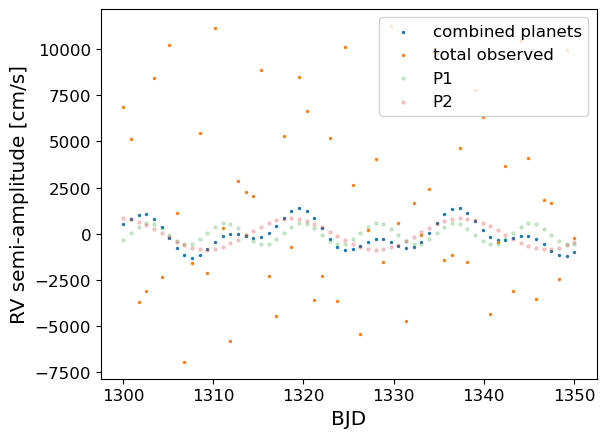

In [6]:
test_t = np.linspace(1300, 1300+50, 60) + np.random.normal(0, 1./24)
test_P1 = 8.46
test_P2 = 18.9
K1 = 580
K2 = 850
T0_1 = 1330.39051
T0_2 = 1342.2223

### create stellar noise
gp = GaussianProcess(kernel, test_t)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))
print(sample)

test_thetas = [[K1, test_P1, T0_1], [K2, test_P2, T0_2]]
y = model_multi(test_t, test_thetas)
plt.scatter(test_t, y, s=2, label='combined planets')
plt.scatter(test_t, y + sample, s=2, label='total observed')

plt.scatter(test_t, calculate_fi.model_jax(test_t, [K1, test_P1, T0_1]), s=5, alpha=0.2, label='P1')
plt.scatter(test_t, calculate_fi.model_jax(test_t, [K2, test_P2, T0_2]), s=5, alpha=0.2, label='P2')

plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.legend()
plt.show()

Ok, this looks tough to do with, you know, the canonical noisy star. How about a known inactive star with multiple planets? Let's try with LHS 1140 (Lillo-Box+ 2020; Ment+ 2019): https://arxiv.org/pdf/2010.06928.pdf; https://iopscience.iop.org/article/10.3847/1538-3881/aaf1b1)

#### LHS 1140 b and c

In [7]:
# stellar parameters, used posteriors from Table B.3 in Lillo-Box+ 2020 
Mstar = 0.191 # solar masses
Prot = 131 # Dittmann+ 2017 (https://ui.adsabs.harvard.edu/abs/2017Natur.544..333D/abstract)
sigma_wn_rv = 1.07 # m/s
sigma_qp_rv = 1.16 # m/s
Tau = 135 # days
eta = -1.04

# planet parameters: 1 is b; 2 is c; and so on
P1 = 24.7
P2 = 3.78
P3 = 78.9 # planet candidate from their RV observations
m1 = 6.38 # Earth masses
m2 = 1.76
m3 = 4.8
T0_1 = 58399.9303
T0_2 = 58389.29382
T0_3 = 58375.0
K1 = utils.calculate_rv(Mstar, m1, P1)
K2 = utils.calculate_rv(Mstar, m2, P2)
K3 = utils.calculate_rv(Mstar, m3, P3)
print(K1, K2)

4.220764378120578 2.1767980955376456


In [8]:
### choose start time as date of this writing
start = '2023-03-07T10:00:00'
start = Time(start, format='isot', scale='utc').jd

### strategy
offs = []
n_obs = 30
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)

cadence = 2
strat = strategy.gappy(cadence = cadence)

In [9]:
### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

# populate list of parameters to feed into cov_matrix_jax()
params = star.param_list()

# build covariance matrix, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

sigma = star.cov_matrix_general(strat, kernel)

In [10]:
### create stellar noise
gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))

### phase fold
t_phase_folded1 = (strat-T0_1) % P1 # phase fold support
t_phase_folded2 = (strat-T0_2) % P1 # phase fold support
#t_phase_folded3 = (strat-T0_3) % P3 # phase fold support

y_phase_folded1 = np.array(calculate_fi.model_jax(t_phase_folded1, [K1, P1, T0_1]))
y_phase_folded2 = np.array(calculate_fi.model_jax(t_phase_folded2, [K2, P2, T0_2]))
#y_phase_folded3 = np.array(calculate_fi.model_jax(t_phase_folded3, K3, P3, T0_3))

In [11]:
"""
plt.plot(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)), label='LHS 1140b')
plt.scatter(strat, np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), s=5, label='LHS 1140c')
plt.scatter(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)) + np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), 
            label='combined planet signal')
#plt.scatter(t_phase_folded2, sample + y_phase_folded1 + y_phase_folded2, label='observed signal')
plt.xlabel(r'BJD')
plt.ylabel('RV semi-amplitude [m/s]')
plt.legend()
plt.show()
"""

"\nplt.plot(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)), label='LHS 1140b')\nplt.scatter(strat, np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), s=5, label='LHS 1140c')\nplt.scatter(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)) + np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), \n            label='combined planet signal')\n#plt.scatter(t_phase_folded2, sample + y_phase_folded1 + y_phase_folded2, label='observed signal')\nplt.xlabel(r'BJD')\nplt.ylabel('RV semi-amplitude [m/s]')\nplt.legend()\nplt.show()\n"

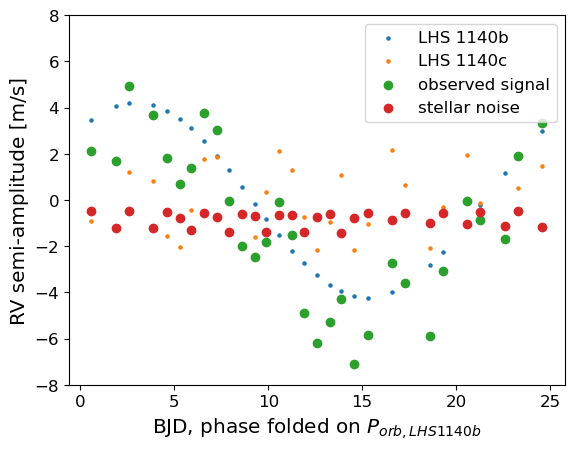

In [12]:
plt.scatter(t_phase_folded1, y_phase_folded1, s=5, label='LHS 1140b')
plt.scatter(t_phase_folded1, y_phase_folded2, s=5, label='LHS 1140c')
#plt.scatter(t_phase_folded1, y_phase_folded1 + y_phase_folded2, label='combined planet signal')
plt.scatter(t_phase_folded1, sample + y_phase_folded1 + y_phase_folded2, label='observed signal')
plt.scatter(t_phase_folded1, sample, label='stellar noise')
plt.xlabel(r'BJD, phase folded on $P_{orb, LHS 1140b}$')
plt.ylabel('RV semi-amplitude [m/s]')
plt.ylim([-8, 8])
plt.legend()
plt.show()


Calculate Fisher Information

In [14]:
flat_theta = [K1, P1, T0_1, K2, P2, T0_2]

In [15]:
jax.config.update("jax_enable_x64", True)

def inner_multi(params):
    #return model_jax_multi_manual(strat, params[0], params[1], params[2], params[3], params[4], params[5])
    return model_jax_multi(strat, params)
    
def inner(params):
    return model_jax(strat, params[0], params[1], params[2])
    
def model_jax_multi(t, flat_theta): 

    """
    JAX-enabled radial velocity model for multi-planet system

    Inputs: 
    - t: time series of length N observations; np.array [day]
    #- thetas: list of lists of [K, P, T0], where:
    - flat_theta: flattened list of lists of [K, P, T0], where:
        - K: RV semi-amplitude [cm/s]
        - P: planet period [days]
        - T0: mean transit time [day]

    Returns: 
    - rv_total: np.array of RV semi-amplitudes

    """
    
    rv_total = np.zeros(len(t))
    #flat_theta = list(chain.from_iterable(thetas))
    
    counter = 0
    while counter < len(flat_theta):  
        K, P, T0 = flat_theta[counter], flat_theta[counter+1], flat_theta[counter+2]
        arg = (2*jnp.pi/P)*(t-T0)
        rv = -K * jnp.sin(arg)
        rv_total += rv
        
        counter += 3
        
    return rv_total

def model_jax_multi_manual(t, K1, P1, T01, K2, P2, T02): 

    """
    JAX-enabled radial velocity model for multi-planet system

    Inputs: 
    - t: time series of length N observations; np.array [day]
    - thetas: list of lists of [K, P, T0], where:
        - K: RV semi-amplitude [cm/s]
        - P: planet period [days]
        - T0: mean transit time [day]

    Returns: 
    - rv_total: np.array of RV semi-amplitudes

    """
    
    arg1 = (2*jnp.pi/P1)*(t-T01)
    rv1 = -K1 * jnp.sin(arg1)
    
    arg2 = (2*jnp.pi/P2)*(t-T02)
    rv2 = -K2 * jnp.sin(arg2)
    rv = rv1 + rv2
    print(rv.shape)
    
    return rv

def model_jax(t, K, P, T0): 

    """
    Radial velocity model, given timestamps and planetary orbital parameters, but JAXified
    (basically, np --> jnp)

    Inputs: 
    - t: time series of length N observations; np.array [day]
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    Returns: 
    - rv: np.array of RV semi-amplitudes

    """

    arg = (2*jnp.pi/P)*(t-T0)
    rv = -K * jnp.sin(arg)
    #print(rv)
    return rv

factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) 
J = np.array(jax.jacobian(inner_multi)(flat_theta))

fim = J @ factor @ J.T
print(fim)

inv_fim = inv(fim)
sigma_k1 = np.sqrt(inv_fim)[0][0]
sigma_k2 = np.sqrt(inv_fim)[3][3]

fi_k = fim[0][0]
print(sigma_k1, sigma_k2)

[[ 1.25390296e+01 -1.53093235e+04 -1.57447432e-01 -1.99556558e-01
   1.40352145e+06  2.20902112e+00]
 [-1.53093235e+04  1.36122839e+11  1.39997308e+06  2.39432920e+04
  -1.18484292e+11 -1.86484285e+05]
 [-1.57447432e-01  1.39997308e+06  1.43982055e+01  2.46250883e-01
  -1.21856584e+06 -1.91791989e+00]
 [-1.99556558e-01  2.39432920e+04  2.46250883e-01  1.43664592e+01
   2.66719752e+06  4.19788290e+00]
 [ 1.40352145e+06 -1.18484292e+11 -1.21856584e+06  2.66719752e+06
   6.22582436e+13  9.79892041e+07]
 [ 2.20902112e+00 -1.86484285e+05 -1.91791989e+00  4.19788290e+00
   9.79892041e+07  1.54226711e+02]]
0.2830194455053482 0.26996240102641295


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9206/1656531540.py:98: RuntimeWarning: invalid value encountered in sqrt
  sigma_k1 = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9206/1656531540.py:99: RuntimeWarning: invalid value encountered in sqrt
  sigma_k2 = np.sqrt(inv_fim)[3][3]


Put planet parameters into a single, flattened list to feed into Fisher Info calculator. 

In [21]:
theta1 = [K1, P1, T0_1]
theta2 = [K2, P2, T0_2]
thetas = [theta1, theta2]
flat_theta = list(chain.from_iterable(thetas))
args = np.array(strat), sigma, jnp.array(flat_theta, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k1 = np.sqrt(inv_fim)[0][0]
sigma_k2 = np.sqrt(inv_fim)[3][3]

fi_k = fim[0][0]
print(sigma_k1, sigma_k2)

0.28301943685969094 0.26996246503213145


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9206/2579603381.py:8: RuntimeWarning: invalid value encountered in sqrt
  sigma_k1 = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9206/2579603381.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigma_k2 = np.sqrt(inv_fim)[3][3]


So, that was the sigma_K for both planets, if we assume both exist. 

In [22]:
args = np.array(strat), sigma, jnp.array(theta1, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

In [23]:
inv_fim = inv(fim)
sigma_k11 = np.sqrt(inv_fim)[0][0]
print(sigma_k11)

0.28260099224054963


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9206/2209798962.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma_k11 = np.sqrt(inv_fim)[0][0]


This is sigma_K on LHS 1140b if we assume c doesn't exist.

In [24]:
args = np.array(strat), sigma, jnp.array(theta2, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k22 = np.sqrt(inv_fim)[0][0]
print(sigma_k22)

0.26983570732677875


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9206/3405677529.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigma_k22 = np.sqrt(inv_fim)[0][0]


This is sigma_K on LHS 1140c if we assume b doesn't exist.

In [26]:
print(sigma_k11 - sigma_k1)
print(sigma_k22 - sigma_k2)

-0.0004184446191413116
-0.00012675770535269804


This means that we overestimate sigma_K when we assume there's no companion. Makes sense so far. It also means that we overestimate sigma_K by more when we assume b has no companion, than when we assume c has no companion. 